In [1]:
import sympy as sp
import numpy as np
from sympy.physics.vector import dynamicsymbols
from sympy.physics.vector import time_derivative
from sympy.physics.vector import ReferenceFrame
N = ReferenceFrame('N')
import pylab as pl
import control
from EoM import *
from sympy.physics.mechanics import *
from numpy.linalg import matrix_rank, eig
import math
import intelligent_robotics as ir
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import WIP_utils as utils
import modern_robotics as mr
import time as t


In [52]:
def get_init_pos(h):
    

    m2 = 1.416
    m3 = 1.739
    m4 = 16.09

    L1 = 0.171
    L2 = 0.28
    L3 = 0.28
    L4 = 0.346

    L2c = L2 - 0.045289
    L3c = L3 - 0.18878
    
    y = h-L1

    theta_3, theta_2 = sp.symbols('theta_3, theta_2')

    A = (y-L4)/L2
    B = m2*L2c + m3*L2+m4*L2
    C = m3*L3c + m4*L3

    f1 = sp.Eq(sp.sin(theta_2)+sp.sin(theta_3),float(A))
    f2 = sp.Eq(float(B)*sp.cos(theta_2)+float(C)*sp.cos(theta_3),0)
    sol = sp.solve([f1,f2])
    # sol
    solu = sol[0]

    theta_2 = solu[theta_2]
    theta_3 = solu[theta_3]
    # theta_2, theta_3
    q2 = theta_2-np.pi/2
    q3 = theta_3-theta_2
    q4 = np.pi/2- theta_3

    thetalistd = np.array([q2, q3, q4])
    
    return thetalistd


In [43]:
def get_end_point(q2, q3, q4):
    m1 = 2.486 + 0.3
    m2 = 1.416
    m3 = 1.739
    m4 = 16.09

    L1 = 0.171
    L2 = 0.28
    L3 = 0.28
    L4 = 0.346

    L1c = L1
    L2c = L2 - 0.045289
    L3c = L3 - 0.18878
    L4c = 0.17188

    theta_2 = np.pi/2 + q2
    theta_3 = np.pi/2 + q2 + q3
    theta_4 = np.pi/2 + q2 + q3 + q4

    x = L2 * sp.cos(theta_2) + L3 * sp.cos(theta_3) + L4 * sp.cos(theta_4)
    z = L2 * sp.sin(theta_2) + L3 * sp.sin(theta_3) + L4 * sp.sin(theta_4)

    x_2 = L2c * sp.cos(theta_2)
    x_3 = L2 * sp.cos(theta_2) + L3c*sp.cos(theta_3)
    x_4 = L2 * sp.cos(theta_2) + L3 * sp.cos(theta_3) + L4c * sp.cos(theta_4)
    x_com = (m2*x_2 + m3*x_3+ m4*x_4) / (m2 + m3 + m4)

    z_2c = L2c * sp.sin(theta_2)
    z_3c = L2 * sp.sin(theta_2) + L3c*sp.sin(theta_3)
    z_4c = L2 * sp.sin(theta_2) + L3 * sp.sin(theta_3) + L4c * sp.sin(theta_4)

    z_com = (m2*z_2c + m3*z_3c + m4*z_4c) / (m2 + m3 + m4)
    theta_P = np.arctan(float(x_com)/float(z_com))
    return x,z, x_com, z_com, theta_P

In [54]:
thetalistd = get_init_pos(0.9)
thetalistd

array([-0.745238866846359, 1.63070174355873, -0.885462876712376],
      dtype=object)

In [55]:
x,z, x_com, z_com, theta_P = get_end_point(thetalistd[0], thetalistd[1], thetalistd[2])
x,z, x_com, z_com, theta_P

(-0.0268969847812644,
 0.728999999999999,
 -1.15377814977933e-17,
 0.500417013226504,
 -2.3056333403618522e-17)

In [56]:
def horizon_traj(x_com, horizon_end, z_com):
    time, traj = utils.Trapezoidal_Traj_Gen_Given_Amax_and_T(1,2,0.015)
    horizon_path = utils.Path_Gen(x_com, horizon_end, traj[:,0])
    
    m1 = 2.486 + 0.3
    m2 = 1.416
    m3 = 1.739
    m4 = 16.09
    m_b = m2+m3+m4

    L1 = 0.171
    L2 = 0.28
    L3 = 0.280
    L4 = 0.346

    L2c = L2 - 0.045289
    L3c = L3 - 0.18878
    L4c = 0.17188
    
    q2list = np.array([thetalistd[0]])
    q3list = np.array([thetalistd[1]])
    q4list = np.array([thetalistd[2]])
    
    for i in range(0, len(time)-1):

        A = m2*L2c + m3*L2+m4*L2
        B = m3*L3c + m4*L3
        C = horizon_path[i] * m_b
        D = m2*L2c + m3*L2+m4*L2
        E = m3*L3c + m4*L3
        F = z_com * m_b - m4*L4c

        theta_2, theta_3 = sp.symbols('theta_2, theta_3')
        f1 = sp.Eq(float(A)*sp.cos(theta_2)+float(B)*sp.cos(theta_3),float(C))
        f2 = sp.Eq(float(D)*sp.sin(theta_2)+float(E)*sp.sin(theta_3),float(F))
        # f3 = sp.Eq(sp.sin(theta_2)+sp.sin(theta_3),float(E))

        sol = sp.solve([f1,f2])
        sol
        solu = sol[0]

        theta_2 = solu[theta_2]
        theta_3 = solu[theta_3]
        # q1 = np.pi/2
        q2 = theta_2-np.pi/2
        q3 = theta_3-theta_2
        q4 = np.pi/2- theta_3
        
        q2list = np.vstack((q2list,q2))
        q3list = np.vstack((q3list,q3))
        q4list = np.vstack((q4list,q4))
        
    return q2list, q3list, q4list



In [57]:
q2list, q3list, q4list = horizon_traj(x_com, 0.05, z_com)

In [72]:
def end_traj(q2list, q3list, q4list):
    m1 = 2.486 + 0.3
    m2 = 1.416
    m3 = 1.739
    m4 = 16.09

    L1 = 0.171
    L2 = 0.28
    L3 = 0.28
    L4 = 0.346

    L1c = L1
    L2c = L2 - 0.045289
    L3c = L3 - 0.18878
    L4c = 0.17188
    
    theta_20 = np.pi/2 + q2list[0]
    theta_30 = np.pi/2 + q2list[0] + q3list[0]
    theta_40 = np.pi/2 + q2list[0] + q3list[0] + q4list[0]

    x = L2 * sp.cos(float(theta_20)) + L3 * sp.cos(float(theta_30)) + L4 * sp.cos(float(theta_40))
    print(x)
    z = L2 * sp.sin(float(theta_20)) + L3 * sp.sin(float(theta_30)) + L4 * sp.sin(float(theta_40))

    x_2 = L2c * sp.cos(float(theta_20))
    x_3 = L2 * sp.cos(float(theta_20)) + L3c*sp.cos(float(theta_30))
    x_4 = L2 * sp.cos(float(theta_20)) + L3 * sp.cos(float(theta_30)) + L4c * sp.cos(float(theta_40))
    x_com = (m2*x_2 + m3*x_3+ m4*x_4) / (m2 + m3 + m4)

    z_2c = L2c * sp.sin(float(theta_20))
    z_3c = L2 * sp.sin(float(theta_20)) + L3c*sp.sin(float(theta_30))
    z_4c = L2 * sp.sin(float(theta_20)) + L3 * sp.sin(float(theta_30)) + L4c * sp.sin(float(theta_40))

    z_com = (m2*z_2c + m3*z_3c + m4*z_4c) / (m2 + m3 + m4)
    theta_P = np.arctan(float(x_com)/float(z_com))
    
    xlist = np.array([x])
    zlist = np.array([z])
    x_comlist = np.array([x_com])
    z_comlist = np.array([z_com])
    theta_Plist = np.array([theta_P])

    for i in range (0, len(q2list)-1):
        
        theta_2 = np.pi/2 + q2list[i]
        theta_3 = np.pi/2 + q2list[i] + q3list[i]
        theta_4 = np.pi/2 + q2list[i] + q3list[i] + q4list[i]

        x = L2 * sp.cos(float(theta_2)) + L3 * sp.cos(float(theta_3)) + L4 * sp.cos(float(theta_4))
        z = L2 * sp.sin(float(theta_2)) + L3 * sp.sin(float(theta_3)) + L4 * sp.sin(float(theta_4))

        x_2 = L2c * sp.cos(float(theta_2))
        x_3 = L2 * sp.cos(float(theta_2)) + L3c*sp.cos(float(theta_3))
        x_4 = L2 * sp.cos(float(theta_2)) + L3 * sp.cos(float(theta_3)) + L4c * sp.cos(float(theta_4))
        x_com = (m2*x_2 + m3*x_3+ m4*x_4) / (m2 + m3 + m4)

        z_2c = L2c * sp.sin(float(theta_2))
        z_3c = L2 * sp.sin(float(theta_2)) + L3c*sp.sin(float(theta_3))
        z_4c = L2 * sp.sin(float(theta_2)) + L3 * sp.sin(float(theta_3)) + L4c * sp.sin(float(theta_4))

        z_com = (m2*z_2c + m3*z_3c + m4*z_4c) / (m2 + m3 + m4)
        theta_P = np.arctan(float(x_com)/float(z_com))
        
        xlist = np.vstack((xlist,x))
        zlist = np.vstack((zlist,z))
        x_comlist = np.vstack((x_comlist,x_com))
        z_comlist = np.vstack((z_comlist,z_com))
        theta_Plist = np.vstack((theta_Plist,theta_P))
        
        
    return xlist,zlist, x_comlist, z_comlist, theta_Plist

In [73]:
xlist,zlist, x_comlist, z_comlist, theta_Plist =  end_traj(q2list, q3list, q4list)

-0.0268969847812644


In [9]:
# def horizon_traj(h_cur, horizon_cur, horizon_end, thetalistd):
#     time, traj = utils.Trapezoidal_Traj_Gen_Given_Amax_and_T(1,2,0.015)
#     horizon_path = utils.Path_Gen(horizon_cur, horizon_end, traj[:,0])
#     m1 = 2.486 + 0.3
#     m2 = 1.416
#     m3 = 1.739
#     m4 = 16.09

#     L1 = 0.171
#     L2 = 0.28
#     L3 = 0.280
#     L4 = 0.346

#     L1c = L1/2
#     L2c = L2 - 0.045289
#     L3c = L3 - 0.18878

#     h = h_cur
#     q1list = np.array([0])
#     q2list = np.array([thetalistd[1]])
#     q3list = np.array([thetalistd[2]])
#     q4list = np.array([thetalistd[3]])

#     for i in range(0, len(time)-1):
        

#         A = (h-L4-L1)/L2
#         B = horizon_path[i]/L2

#         theta_2, theta_3 = sp.symbols('theta_2, theta_3')
#         f1 = sp.Eq(sp.sin(theta_2)+sp.sin(theta_3),float(A))
#         f2 = sp.Eq(sp.cos(theta_2)+sp.cos(theta_3),float(B))
#         # f3 = sp.Eq(sp.sin(theta_2)+sp.sin(theta_3),float(E))

#         sol = sp.solve([f1,f2])
#         solu = sol[0]

#         theta_2 = solu[theta_2]
#         theta_3 = solu[theta_3]
#         q1 = np.pi/2
#         q2 = theta_2-q1
#         q3 = theta_3-q1-q2
#         q4 = -(q2+q3)

#         q1list = np.vstack((q1list,0))
#         q2list = np.vstack((q2list,q2))
#         q3list = np.vstack((q3list,q3))
#         q4list = np.vstack((q4list,q4))

    

#     return q1list, q2list, q3list, q4list

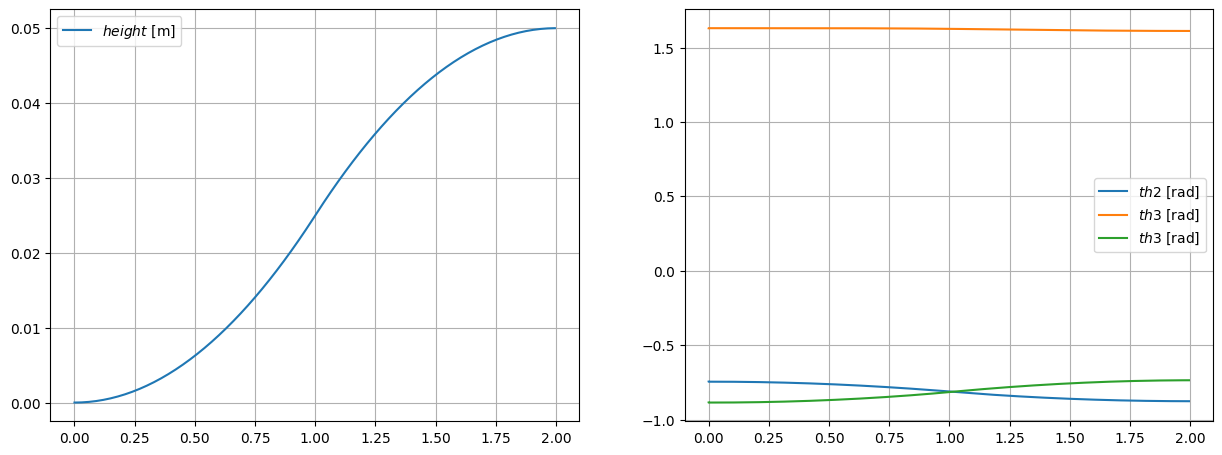

In [60]:
time, traj = utils.Trapezoidal_Traj_Gen_Given_Amax_and_T(1,2,0.015)
height_path = utils.Path_Gen(0, 0.05, traj[:,0])

pl.figure(1, figsize=(15,12), dpi=100)
pl.subplot(221);
pl.plot(time, height_path);
pl.legend([r'$height$ [m]'], loc='best')
pl.grid()

plt.grid(True, axis='y')

pl.figure(1, figsize=(15,12), dpi=150)
pl.subplot(222);
pl.plot( time, q2list, time, q3list, time, q4list );
pl.legend([r'$th2$ [rad]', r'$th3$ [rad]', r'$th3$ [rad]', r'$th4$ [rad]'], loc='best')
pl.grid()

plt.grid(True, axis='y')

plt.show()

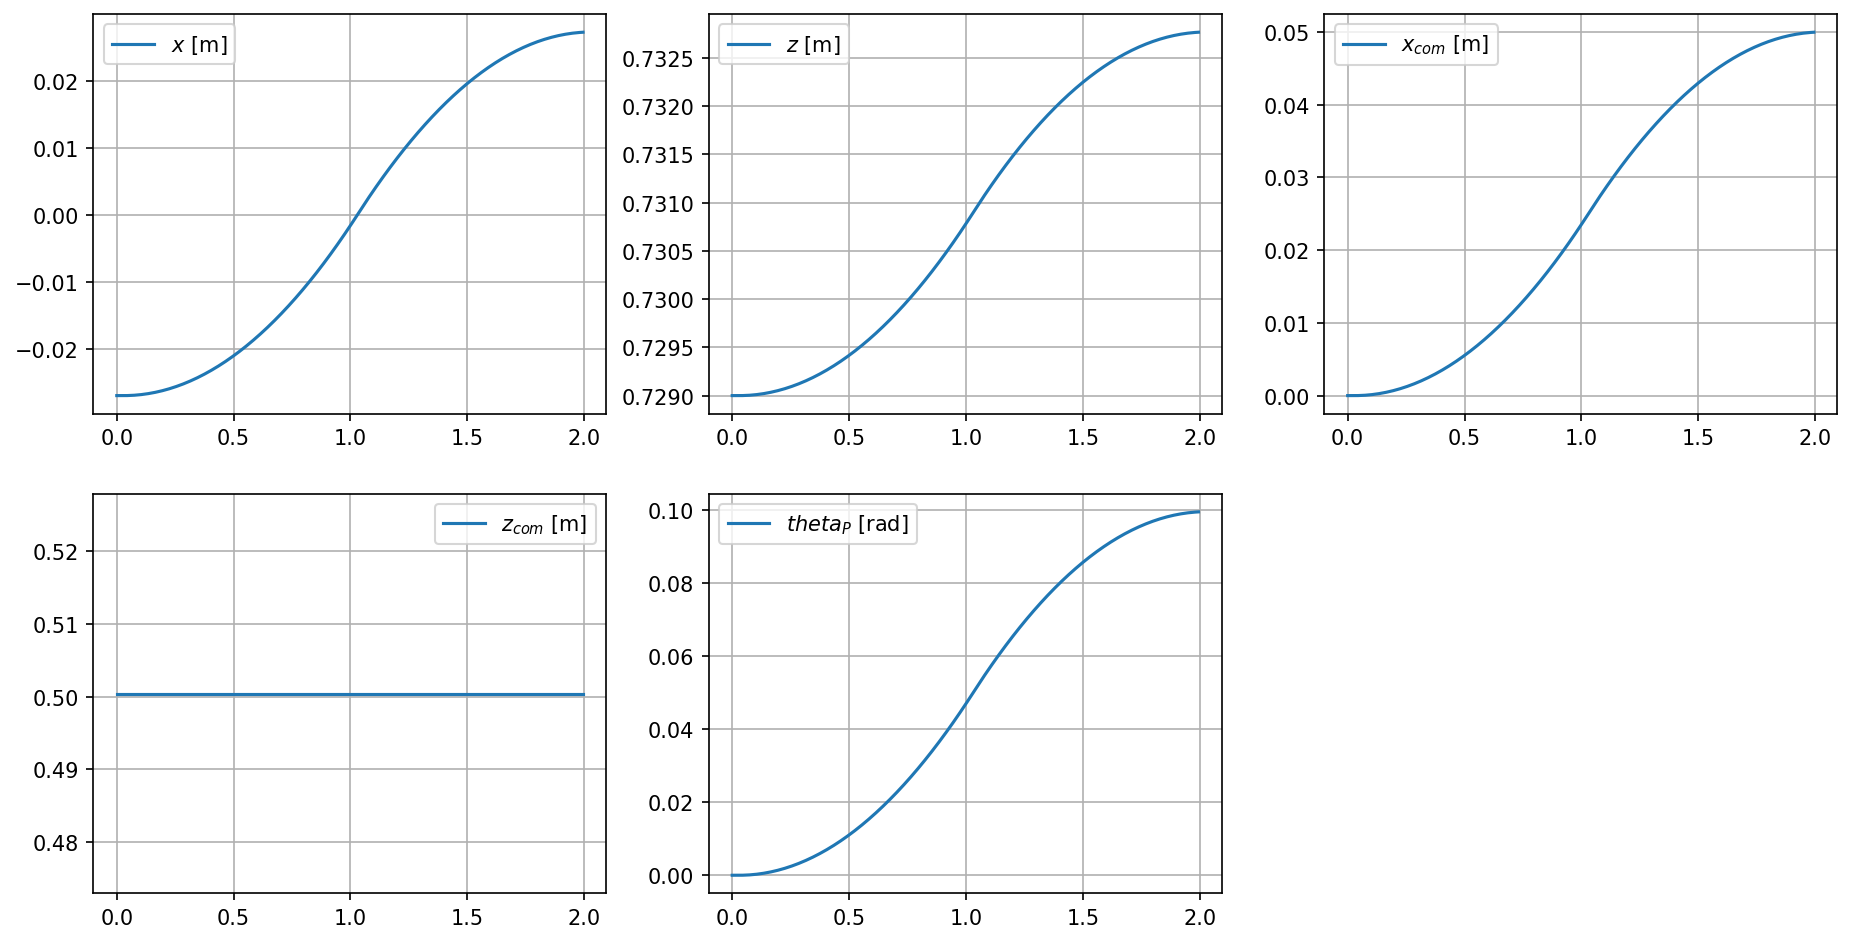

In [78]:
time, traj = utils.Trapezoidal_Traj_Gen_Given_Amax_and_T(1,2,0.015)
height_path = utils.Path_Gen(0, 0.05, traj[:,0])
xlist,zlist, x_comlist, z_comlist, theta_Plist

pl.figure(1, figsize=(15,12), dpi=150)
pl.subplot(331);
pl.plot(time, xlist);
pl.legend([r'$x$ [m]'], loc='best')
pl.grid()

pl.figure(1, figsize=(15,12), dpi=150)
pl.subplot(332);
pl.plot(time, zlist);
pl.legend([r'$z$ [m]'], loc='best')
pl.grid()

pl.figure(1, figsize=(15,12), dpi=150)
pl.subplot(333);
pl.plot(time, x_comlist);
pl.legend([r'$x_{com}$ [m]'], loc='best')
pl.grid()

pl.figure(1, figsize=(15,12), dpi=150)
pl.subplot(334);
pl.plot(time, z_comlist);
pl.legend([r'$z_{com}$ [m]'], loc='best')
pl.grid()

pl.figure(1, figsize=(15,12), dpi=150)
pl.subplot(335);
pl.plot(time, theta_Plist);
pl.legend([r'$theta_P$ [rad]'], loc='best')
pl.grid()


plt.show()

In [16]:
def get_torque_traj(q1list, q2list, q3list, q4list):
    time, traj = utils.Trapezoidal_Traj_Gen_Given_Amax_and_T(1,2,0.015)
    # thetalist = get_cur_deg()
    
    m1 = 2.486 + 0.3
    m2 = 1.416
    m3 = 1.739
    m4 = 16.09

    L1 = 0.171
    L2 = 0.28
    L3 = 0.280
    L4 = 0.346

    L1c = L1/2
    L2c = L2 - 0.045289
    L3c = L3 - 0.18878
    L4c = 0.158527

    traj_th1 = q1list
    traj_th2 = q2list
    traj_th3 = q3list
    traj_th4 = q4list

    eint = np.array([[0.2], [0.2], [0.2], [0.2]])
    g = np.array([0, 0, -9.8])
    theta_2 = 0
    theta_3 = 0
    
    M01 = np.array([[1, 0, 0,       0],
                    [0, 1, 0,       0],
                    [0, 0, 1,       0],
                    [0, 0, 0,       1]])
    
    M12 = np.array([[1, 0, 0,        0],
                    [0, 1, 0,       L1c],
                    [0, 0, 1,        0],
                    [0, 0, 0,        1]])
    
    M23 = np.array([[ 1, 0, 0,      0],
                    [ 0, 1, 0,      L2c],
                    [ 0, 0, 1,       0],
                    [ 0, 0, 0,       1]])
    
    M34 = np.array([[1, 0, 0,       0],
                    [0, 1, 0,       L3c],
                    [0, 0, 1,      0],
                    [0, 0, 0,       1]])
    
    M45 = np.array([[1, 0, 0,       0],
                    [0, 1, 0,      L4c],
                    [0, 0, 1,       0],
                    [0, 0, 0,       1]])
    
    G1 = np.diag([0.00613516, 0.00614941, 0.004981955, m1, m1, m1]) 
    G2 = np.diag([0.010192583, 0.009599672, 0.002390603, m2, m2, m2])
    G3 = np.diag([0.008595913, 0.007917693, 0.002944951, m3, m3, m3])
    G4 = np.diag([0.306643651, 0.257336003, 0.140868631, m4, m4, m4]) 
    
    Glist = np.array([G1, G2, G3, G4])
    Mlist = np.array([M01, M12, M23, M34, M45])
    Slist = np.array([[0, 0, 1,      0, 0,     0],
                      [0, 0, -1,   -L1, 0,     0],
                      [0, 0, 1, L1 + L2, 0, 0.0],
                      [0, 0, -1, -(L1 + L2 +L3 ), 0 , 0.0]]).T
    Kp = 0.1
    Ki = 0.1
    Kd = 0.1
    dt = 0.03

    torquelist = np.array([[0],[0],[0],[0]])
    dthetalist = np.array([[0], [0], [0], [0]])
    

    for i in range(0, len(time)-1):

        thetalist = np.array([traj_th1[i], traj_th2[i], traj_th3[i], traj_th4[i]],dtype=float)
        thetalistd = np.array([traj_th1[i+1], traj_th2[i+1], traj_th3[i+1], traj_th4[i+1]],dtype=float)
        
        dthetalistd = np.array([(traj_th1[i+1]-traj_th1[i])/dt, (traj_th2[i+1]-traj_th2[i])/dt, (traj_th3[i+1]-traj_th3[i])/dt, (traj_th4[i+1]-traj_th4[i])/dt],dtype=float)
        ddthetalistd = np.array([(dthetalistd[0]-dthetalist[0])/dt, (dthetalistd[1]-dthetalist[1])/dt, (dthetalistd[2]-dthetalist[2])/dt, (dthetalistd[3]-dthetalist[3])/dt],dtype=float)

        # torque = mr.ComputedTorque(thetalist, dthetalist, eint, g, Mlist, Glist, Slist,thetalistd, dthetalistd, ddthetalistd, Kp, Ki, Kd)

        # torquelist = np.vstack((torquelist,torque))  
        # dthetalist = dthetalistd

        e = np.subtract(thetalistd, thetalist)
        # print(np.subtract(dthetalistd, dthetalist))

        a = mr.MassMatrix(thetalist, Mlist, Glist, Slist)
        c = Kp * e + Ki * (np.array(eint) + e) \
                + Kd * (np.subtract(dthetalistd, dthetalist))
        # print(a)
        # print( Ki * (np.array(eint) + e))
        
        b = np.array([mr.InverseDynamics(thetalist, dthetalist, ddthetalistd, g, \
                            [0, 0, 0, 0, 0, 0], Mlist, Glist, Slist)]).T
        torque = np.dot(a,c)+b
        # print(a).
        print(thetalistd)
        print(thetalist)
        print(dthetalistd)
        print(dthetalist)
   
        torquelist = np.vstack((torquelist,torque))  
        dthetalist = dthetalistd
        
        
        # print('------------------------')

        
    return torquelist

In [17]:
torquelist = get_torque_traj(q1list, q2list, q3list, q4list)
torquelist.shape

[[ 0.        ]
 [-0.74523887]
 [ 1.63070174]
 [-0.88546288]]
[[ 0.        ]
 [-0.74523887]
 [ 1.63070174]
 [-0.88546288]]
[[ 0.00000000e+00]
 [-3.70074342e-15]
 [-1.48029737e-14]
 [ 1.85037171e-14]]
[[0]
 [0]
 [0]
 [0]]
[[ 0.        ]
 [-0.74523887]
 [ 1.63070174]
 [-0.88546288]]
[[ 0.        ]
 [-0.74523887]
 [ 1.63070174]
 [-0.88546288]]
[[0.]
 [0.]
 [0.]
 [0.]]
[[ 0.00000000e+00]
 [-3.70074342e-15]
 [-1.48029737e-14]
 [ 1.85037171e-14]]
[[ 0.        ]
 [-0.74527841]
 [ 1.63070665]
 [-0.88542824]]
[[ 0.        ]
 [-0.74523887]
 [ 1.63070174]
 [-0.88546288]]
[[ 0.        ]
 [-0.00131812]
 [ 0.00016351]
 [ 0.00115462]]
[[0.]
 [0.]
 [0.]
 [0.]]
[[ 0.        ]
 [-0.74539703]
 [ 1.63072135]
 [-0.88532431]]
[[ 0.        ]
 [-0.74527841]
 [ 1.63070665]
 [-0.88542824]]
[[ 0.        ]
 [-0.00395415]
 [ 0.00049   ]
 [ 0.00346415]]
[[ 0.        ]
 [-0.00131812]
 [ 0.00016351]
 [ 0.00115462]]
[[ 0.        ]
 [-0.74559472]
 [ 1.6307458 ]
 [-0.88515108]]
[[ 0.        ]
 [-0.74539703]
 [ 1.63072135

(540, 1)

In [19]:
torque = torquelist.reshape(135,4)

In [25]:
torque[0]

0.0

In [26]:
len(torque)

135

In [ ]:
a = torquelist.tolist()
type(a)

list

In [ ]:
torquelist.shape

(269, 4)

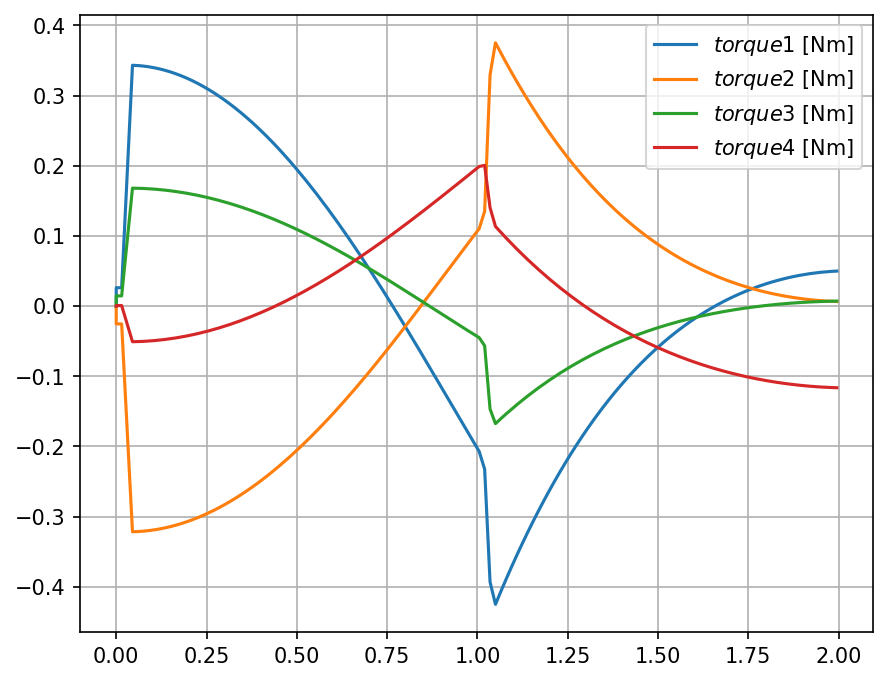

In [21]:
time, traj = utils.Trapezoidal_Traj_Gen_Given_Amax_and_T(1,2,0.015)

pl.figure(1, figsize=(15,12), dpi=150)
pl.subplot(221);
pl.plot(time,torque);
pl.legend([r'$torque1$ [Nm]', r'$torque2$ [Nm]', r'$torque3$ [Nm]', r'$torque4$ [Nm]'], loc='best')
pl.grid()

plt.grid(True, axis='y')

plt.show()

In [ ]:
time1, traj1 = utils.Trapezoidal_Traj_Gen_Given_Amax_and_T(1,2,0.03)
time1.shape

(68, 1)